In [176]:
import ast
import math
import json
import re
import matplotlib.pyplot as plt

In [160]:
def load_jsonl(path: str):
    with open(path) as f:
        return [json.loads(line) for line in f.readlines() if line]

In [161]:
train = load_jsonl("train.jsonl")

In [162]:
answer_c = [
    re.findall(r"<<([^<>]+=[^<>]+)>>", e["answer"]) # + re.findall(r"\#\#\#\#\s*(\S+)\s*", e["answer"]) 
    for e in train ]
answer_q = [
    sorted((float(n) for n in set(re.findall(r"\d+(?:\.\d+)?", e["question"]) + re.findall(r"\d+", e["answer"]))))
    for e in train]
answer_cq = [
    sorted((float(n) for c in e for n in re.findall(r"\d+(?:\.\d+)?", c))) for e in answer_c]
answer_cq_unique = [sorted(n for n in (set(cqs))) for cqs in answer_cq]

In [163]:
features_ord = sorted(zip(answer_c, answer_q, answer_cq, answer_cq_unique, train), key=lambda e: len(e[0]))
answer_c, answer_q, answer_cq, answer_cq_unique, train = (
    [t[0] for t in features_ord], 
    [t[1] for t in features_ord], 
    [t[2] for t in features_ord], 
    [t[3] for t in features_ord],
    [t[4] for t in features_ord])
keep = [answer_q[i] == answer_cq_unique[i] for i in range(len(features_ord))]

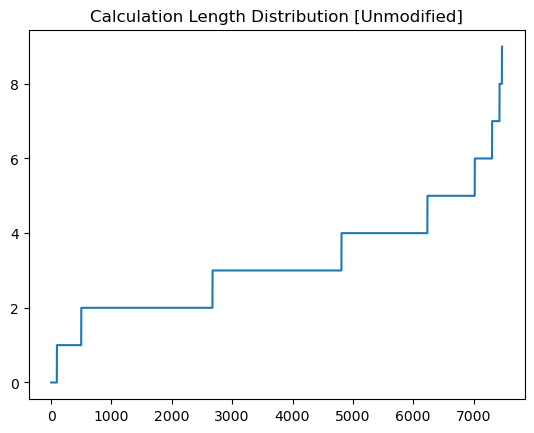

In [164]:
plt.plot(list(range(len(answer_c))), [len(c) for c in answer_c])
plt.title("Calculation Length Distribution [Unmodified]")
plt.show()

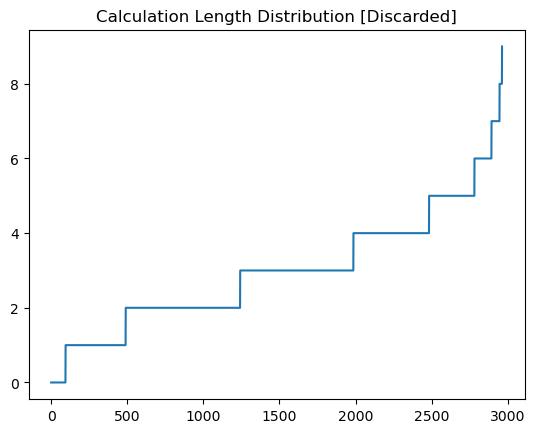

In [165]:
discarded_sizes = [len(c) for c in [c for (j, c) in enumerate(answer_c) if not keep[j]]]
plt.plot(list(range(len(discarded_sizes))), discarded_sizes)
plt.title("Calculation Length Distribution [Discarded]")
plt.show()

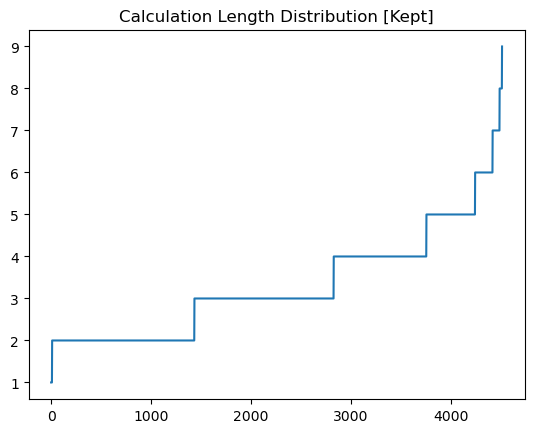

In [166]:
kept_sizes = [len(c) for c in [c for (j, c) in enumerate(answer_c) if keep[j]]]
plt.plot(list(range(len(kept_sizes))), kept_sizes)
plt.title("Calculation Length Distribution [Kept]")
plt.show()

In [167]:
answer_c, answer_q, answer_cq, answer_cq_unique, train = (
    [a for (j, a) in enumerate(answer_c) if keep[j]],
    [a for (j, a) in enumerate(answer_q) if keep[j]],
    [a for (j, a) in enumerate(answer_cq) if keep[j]],
    [a for (j, a) in enumerate(answer_cq_unique) if keep[j]],
    [a for (j, a) in enumerate(train) if keep[j]])

In [177]:
i = math.floor(2 * len(answer_c) / 3)
print(f"Q: {train[i]['question']}\n\nA: {train[i]['answer']}\n\ncalculations: {answer_c[i]}\n\nquantities: {answer_q[i]}\n\nquantities in calculations: {answer_cq[i]}")

Q: Jack goes up three flights of stairs, then down six flights of stairs. If each flight of stairs has 12 steps that each each 8 inches high, how many feet further down is Jack than when he started?

A: First find the number of inches in each flight of stairs: 12 steps * 8 inches/step = <<12*8=96>>96 inches
Then find the net number of flights of stairs Jack went down: 6 flights - 3 flights = <<6-3=3>>3 flights
Then multiply than number by the number of inches per flight to find how many inches further down he is: 96 inches/flight * 3 flights = <<96*3=288>>288 inches
Then divide that number by 12 to find the number of feet down he is: 288 inches / 12 inches/foot = <<288/12=24>>24 feet
#### 24

calculations: ['12*8=96', '6-3=3', '96*3=288', '288/12=24']

quantities: [3.0, 6.0, 8.0, 12.0, 24.0, 96.0, 288.0]

quantities in calculations: [3.0, 3.0, 3.0, 6.0, 8.0, 12.0, 12.0, 24.0, 96.0, 96.0, 288.0, 288.0]


In [115]:
answer_calc_all = [e for c in answer_calc for e in c]
answer_calc_all_ord = sorted(answer_calc_all, key=lambda e: len(re.findall(r"\d+(?:\.\d+)?", e)))

In [116]:
answer_calc_ast = [ast.parse(c.replace(",", "").split("=")[0]) for c in answer_calc_all_ord]

In [122]:
print(answer_calc_all_ord[-3].replace(",", "").split("=")[0])
print(ast.dump(answer_calc_ast[-3], indent=4))

1/2*30+1/2*40+1/2*50
Module(
    body=[
        Expr(
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=BinOp(
                            left=Constant(value=1),
                            op=Div(),
                            right=Constant(value=2)),
                        op=Mult(),
                        right=Constant(value=30)),
                    op=Add(),
                    right=BinOp(
                        left=BinOp(
                            left=Constant(value=1),
                            op=Div(),
                            right=Constant(value=2)),
                        op=Mult(),
                        right=Constant(value=40))),
                op=Add(),
                right=BinOp(
                    left=BinOp(
                        left=Constant(value=1),
                        op=Div(),
                        right=Constant(value=2)),
                    op=Mult(),
               

In [128]:
answer_calc_ast[-3].body[0].value

In [101]:
answer_calc_all_ord[-10:]

['10+14+18+22+26+30=120',
 '40+50+65+36+82+72+26=371',
 '7+12+14+12+5+18+12=80',
 '40+200+300+130+40+80+444=1234',
 '.25+.5+.75+1+1.25+1.5+1.75=7',
 '1+3+5+7+9+11+13=49',
 '2+2+2+1/3+1/3+1/3=7',
 '1/2*30+1/2*40+1/2*50=60',
 '1+3+2+4+3+5+6+1+4+2=31',
 '2*100+1*50+5*20+3*10+7*5+27*1=442']

In [90]:
n_operands = [len(re.findall(r"\d+", c)) for c in answer_calc_all if "=" in c]

In [87]:
operations = [o for c in answer_calc_all for o in re.findall(r"([^\d=.,()]+)[+-]?", c)]

In [129]:
set(o for o in operations if len(o) == 1 or o[-1] not in ["-", "+"])

{'*', '+', '-', '/', '//'}

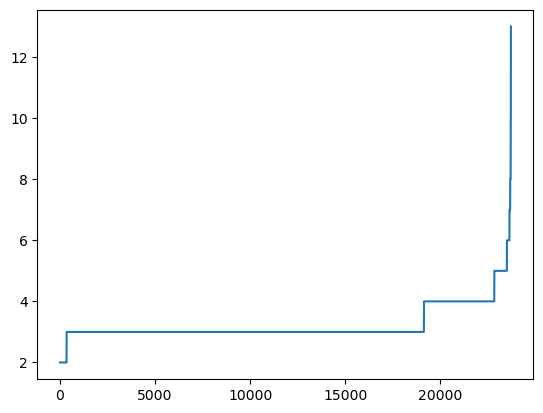

In [91]:
plt.plot(list(range(len(n_operands))), sorted(n_operands))